### The files generated here can be used with the notebook in this folder called location_validation_gui.ipynb for human validation of map locations

This notebooks generates a specified number of random crops around track locations in both the drone video and the same estimated location in the landscape orthomosaic. With the accompanying GUI a person can click on the actual location on the map that corresponds to the location the animal is standing in the video frame. The notebook 'human_groundtruth_validation.ipynb' calculates the difference between the computer and human locations in the map.

In [1]:
import json
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

# local .json file with local path info
ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import mapping_functions as kmap
import koger_general_functions as kgf

In [2]:
observation_name = "observation088"
pix4d_project_name = "observation088"
tracks_name = "tracks-complete.npy"

# new_style should be True is using file format used througout worked examples
new_style = True

pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name, load_ortho=True)

root_folder = os.path.join(local_paths["processed_folder"], observation_name)
if new_style:
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               tracks_name)
else:   
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               "localizations", tracks_name)
tracks_frame = np.load(tracks_file, allow_pickle=True)

utms_file = os.path.join(pix4d_folder, 'utm_tracks.npy')
tracks_utm = np.load(utms_file, allow_pickle=True)

frame_folders_root = os.path.join(local_paths["base_frames_folder"], observation_name) 
frame_files = kgf.get_observation_frame_files(frame_folders_root)

anchor_obs_inds = kmap.get_anchor_obs_indexes(pix4d_info['pmatrices'], 
                                              frame_files=frame_files)

In [5]:
np.random.seed(0) # was 0

save = True
show = False

# How many validation examples to extract
vals_per_observation = 350
map_buffer = 8 # meters
frame_buffer = 200

use_gt_inds = False

# Make the folders where the images and files needed for human validation will
# be saved
output_folder = os.path.join(pix4d_folder, "validation")
os.makedirs(output_folder, exist_ok=True)

output_frame_folder = os.path.join(output_folder, 'video_frames')
os.makedirs(output_frame_folder, exist_ok=True)
output_map_images_folder = os.path.join(output_folder, 'map_images')
os.makedirs(output_map_images_folder, exist_ok=True)
output_frame_positions_folder = os.path.join(output_folder, 'frame_positions')
os.makedirs(output_frame_positions_folder, exist_ok=True)
output_raster_positions_folder = os.path.join(output_folder, 'estimated_raster_positions')
os.makedirs(output_raster_positions_folder, exist_ok=True)
output_track_indicies_folder = os.path.join(output_folder, 'track_indicies')
os.makedirs(output_track_indicies_folder, exist_ok=True)

# get some number of randomly chosen frames
if use_gt_inds:
    # Might just want to us anchor frames to seperatte error from 
    # projection into the map and error from adding local drone movement
    # estimation.
    print('using gt inds')
    obs_inds = np.random.choice(anchor_obs_inds, vals_per_observation)
else:
    obs_inds = np.random.randint(0, len(frame_files), vals_per_observation)

all_frame_positions = []
all_raster_positions = []
all_track_indicies = []
for obs_ind in obs_inds:
    frame = cv2.imread(frame_files[obs_ind])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find active tracks in this obs_ind
    active_track_inds = np.nonzero(~np.isnan(tracks_utm[:, obs_ind, 0]))[0]

    if len(active_track_inds) == 0:
        continue

    # pick one of these tracks randomly
    track_inds = [random.choice(active_track_inds)]

    for track_ind in track_inds:
        track_frame = tracks_frame[track_ind]
        rel_frame_num = kgf.get_tracks_rel_frame_num(track_frame, obs_ind)
        x_utm, y_utm = tracks_utm[track_ind, obs_ind]

        min_x_utm = x_utm - map_buffer
        max_x_utm = x_utm + map_buffer
        min_y_utm = y_utm - map_buffer
        max_y_utm = y_utm + map_buffer

        x_raster, y_raster = kmap.utm_to_raster(x_utm, y_utm, pix4d_info)

        min_x_raster, min_y_raster = kmap.utm_to_raster(min_x_utm, min_y_utm, 
                                                        pix4d_info)
                                                       

        max_x_raster, max_y_raster = kmap.utm_to_raster(max_x_utm, max_y_utm, 
                                                        pix4d_info)

        x_frame = track_frame['track'][rel_frame_num, 1]
        y_frame = frame.shape[0] - track_frame['track'][rel_frame_num, 0]

        name = "{}-obs_ind-{}-track-{}".format(observation_name, obs_ind, track_ind)

        frame = cv2.imread(frame_files[obs_ind])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        max_x_raster_utm = np.min([max_x_raster, pix4d_info['ortho'].shape[1]])
        min_x_raster_utm = np.max([min_x_raster, 0])
        max_y_raster_utm = np.min([max_y_raster, pix4d_info['ortho'].shape[0]])
        min_y_raster_utm = np.max([min_y_raster, 0])

        min_y_raster = np.min([min_y_raster_utm, max_y_raster_utm])
        max_y_raster = np.max([min_y_raster_utm, max_y_raster_utm])
        min_x_raster = np.min([min_x_raster_utm, max_x_raster_utm])
        max_x_raster = np.max([min_x_raster_utm, max_x_raster_utm])

        max_x_frame = np.min([x_frame+frame_buffer, frame.shape[1]]).astype(int)
        min_x_frame = np.max([x_frame-frame_buffer, 0]).astype(int)
        max_y_frame = np.min([y_frame+frame_buffer, frame.shape[0]]).astype(int)
        min_y_frame = np.max([y_frame-frame_buffer, 0]).astype(int)


        cropped_ortho = pix4d_info['ortho'][min_y_raster:max_y_raster, 
                                            min_x_raster:max_x_raster]
        cropped_frame = frame[min_y_frame:max_y_frame, 
                              min_x_frame:max_x_frame]


        if show:
            plt.figure(figsize=(10,10))
            plt.imshow(cropped_ortho)
            plt.scatter(x_raster-min_x_raster, y_raster-min_y_raster, s=100)
            plt.title('obs ind {}, track ind {}'.format(obs_ind, track_ind, observation_name))
            plt.figure(figsize=(10,10))
            plt.imshow(cropped_frame)
            plt.title('obs ind {}, track ind {}'.format(obs_ind, track_ind, observation_name))

        # first point is the minx and miny
        cropped_frame_positions = [np.array([min_x_frame, min_y_frame])]
        cropped_map_positions = [np.array([min_x_raster, min_y_raster])]

        if show:
            plt.scatter(x_frame-min_x_frame, y_frame-min_y_frame, s=30)
        cropped_frame_positions.append(np.array([x_frame-min_x_frame, y_frame-min_y_frame]))
        cropped_map_positions.append(np.array([-1, -1])) # These will be corrected in the gui

        if save:
            if not os.path.isfile(os.path.join(output_raster_positions_folder, name+'.npy')):
                np.save(os.path.join(output_frame_positions_folder, name+'.npy'),
                        np.vstack(cropped_frame_positions))
                np.save(os.path.join(output_raster_positions_folder, name+'.npy'),
                        np.vstack(cropped_map_positions))
                np.save(os.path.join(output_track_indicies_folder, name+'.npy'),
                        np.array([track_ind]))  
                cropped_ortho = cv2.cvtColor(cropped_ortho, cv2.COLOR_BGR2RGB)
                cropped_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
                cv2.imwrite(os.path.join(output_frame_folder, name+'.jpg'), cropped_frame)
                cv2.imwrite(os.path.join(output_map_images_folder, name+'.jpg'), cropped_ortho)

### Sometimes its nice to see the projected location of a specific track in a specific frame

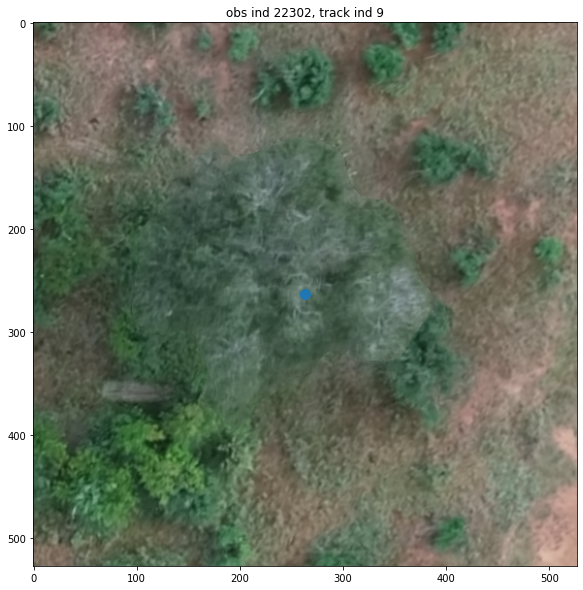

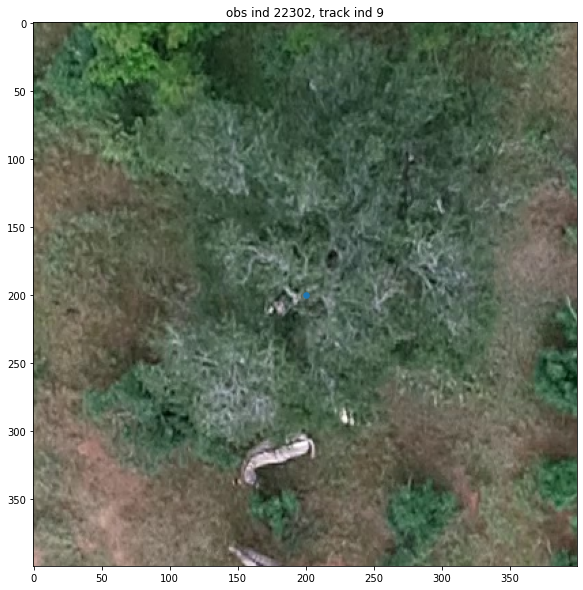

In [6]:
vals_per_observation = 1
map_buffer = 8 # meters
frame_buffer = 200
    
obs_inds = [22302]
track_inds = [9]

all_frame_positions = []
all_raster_positions = []
all_track_indicies = []
for obs_ind in obs_inds:
    frame = cv2.imread(frame_files[obs_ind])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    for track_ind in track_inds:
        track_frame = tracks_frame[track_ind]
        rel_frame_num = kgf.get_tracks_rel_frame_num(track_frame, obs_ind)
        x_utm, y_utm = tracks_utm[track_ind, obs_ind]

        min_x_utm = x_utm - map_buffer
        max_x_utm = x_utm + map_buffer
        min_y_utm = y_utm - map_buffer
        max_y_utm = y_utm + map_buffer

        x_raster, y_raster = kmap.utm_to_raster(x_utm, y_utm, pix4d_info)

        min_x_raster, min_y_raster = kmap.utm_to_raster(min_x_utm, min_y_utm, 
                                                        pix4d_info)
                                                       

        max_x_raster, max_y_raster = kmap.utm_to_raster(max_x_utm, max_y_utm, 
                                                        pix4d_info)

        x_frame = track_frame['track'][rel_frame_num, 1]
        y_frame = frame.shape[0] - track_frame['track'][rel_frame_num, 0]

        name = "{}-obs_ind-{}-track-{}".format(observation_name, obs_ind, track_ind)

        frame = cv2.imread(frame_files[obs_ind])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        max_x_raster_utm = np.min([max_x_raster, pix4d_info['ortho'].shape[1]])
        min_x_raster_utm = np.max([min_x_raster, 0])
        max_y_raster_utm = np.min([max_y_raster, pix4d_info['ortho'].shape[0]])
        min_y_raster_utm = np.max([min_y_raster, 0])

        min_y_raster = np.min([min_y_raster_utm, max_y_raster_utm])
        max_y_raster = np.max([min_y_raster_utm, max_y_raster_utm])
        min_x_raster = np.min([min_x_raster_utm, max_x_raster_utm])
        max_x_raster = np.max([min_x_raster_utm, max_x_raster_utm])

        max_x_frame = np.min([x_frame+frame_buffer, frame.shape[1]]).astype(int)
        min_x_frame = np.max([x_frame-frame_buffer, 0]).astype(int)
        max_y_frame = np.min([y_frame+frame_buffer, frame.shape[0]]).astype(int)
        min_y_frame = np.max([y_frame-frame_buffer, 0]).astype(int)


        cropped_ortho = pix4d_info['ortho'][min_y_raster:max_y_raster, 
                                            min_x_raster:max_x_raster]
        cropped_frame = frame[min_y_frame:max_y_frame, 
                              min_x_frame:max_x_frame]


        if show:
            plt.figure(figsize=(10,10))
            plt.imshow(cropped_ortho)
            plt.scatter(x_raster-min_x_raster, y_raster-min_y_raster, s=100)
            plt.title('obs ind {}, track ind {}'.format(obs_ind, track_ind, observation_name))
            plt.figure(figsize=(10,10))
            plt.imshow(cropped_frame)
            plt.title('obs ind {}, track ind {}'.format(obs_ind, track_ind, observation_name))

        # first point is the minx and miny
        cropped_frame_positions = [np.array([min_x_frame, min_y_frame])]
        cropped_map_positions = [np.array([min_x_raster, min_y_raster])]

        if show:
            plt.scatter(x_frame-min_x_frame, y_frame-min_y_frame, s=30)
        cropped_frame_positions.append(np.array([x_frame-min_x_frame, y_frame-min_y_frame]))
        cropped_map_positions.append(np.array([-1, -1])) # These will be corrected in the gui
